In [ ]:
!pip install ultralytics datasets --upgrade -q



image 1/1 /content/aadhar_pratham.jpeg: 448x640 1 face, 997.1ms
Speed: 4.2ms preprocess, 997.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


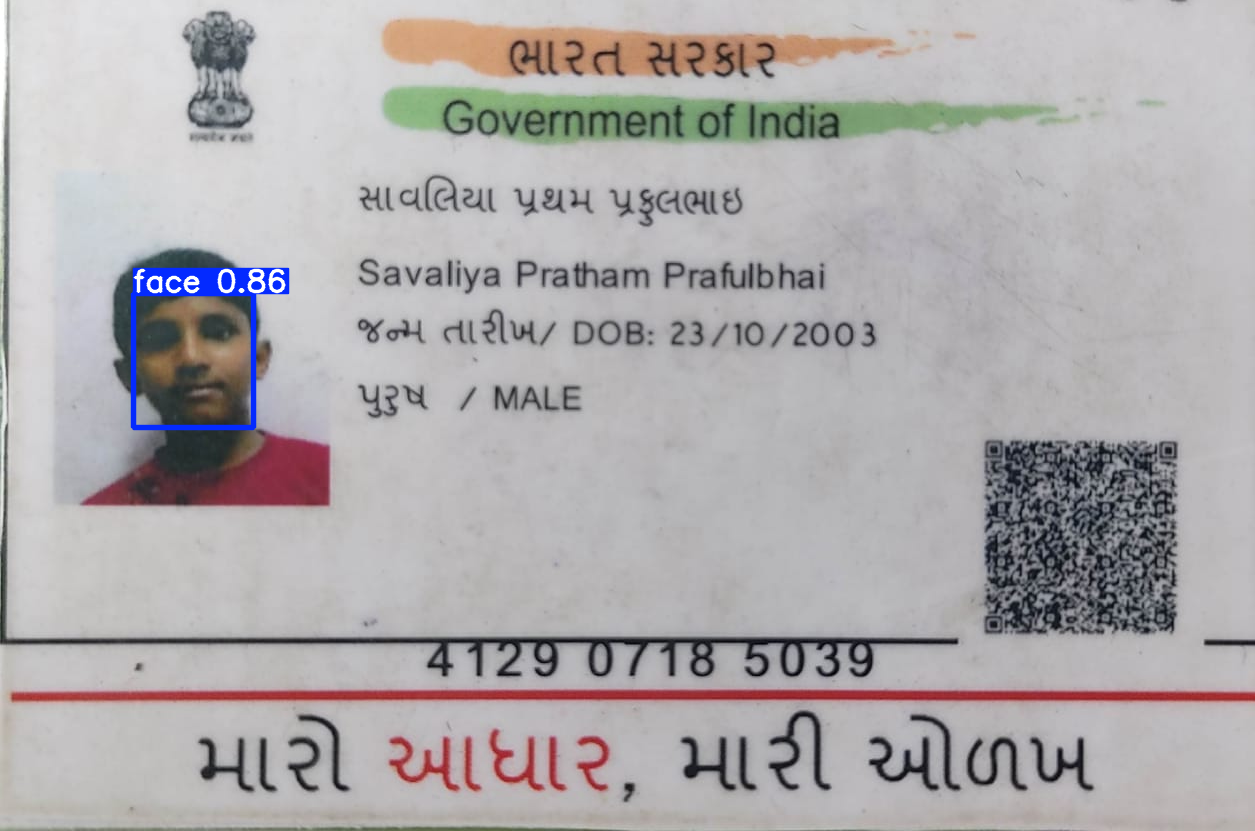

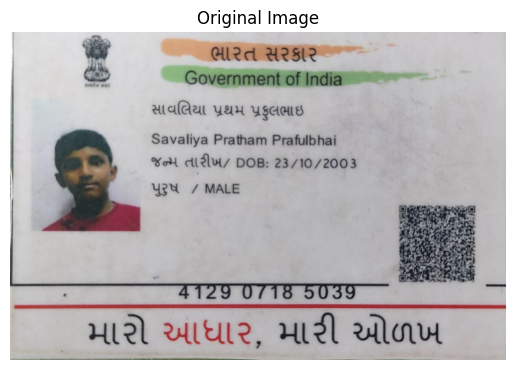

Time Taken: 2.0921566486358643


In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import time


start_time = time.time()


image_path = "/content/opencv-lena.jpg"

model = YOLO("/content/yolov11m-face.pt")



results = model(image_path)

results[0].show()

# Optional: Display in notebook
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")
plt.show()


print(f"Time Taken: {time.time() - start_time}")


In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): C3k(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv3): Con

In [ ]:
from datasets import load_dataset

dataset = load_dataset("CUHK-CSE/wider_face")

train_data = dataset["train"]



In [ ]:
valid = dataset["validation"]
valid

Dataset({
    features: ['image', 'faces'],
    num_rows: 3226
})

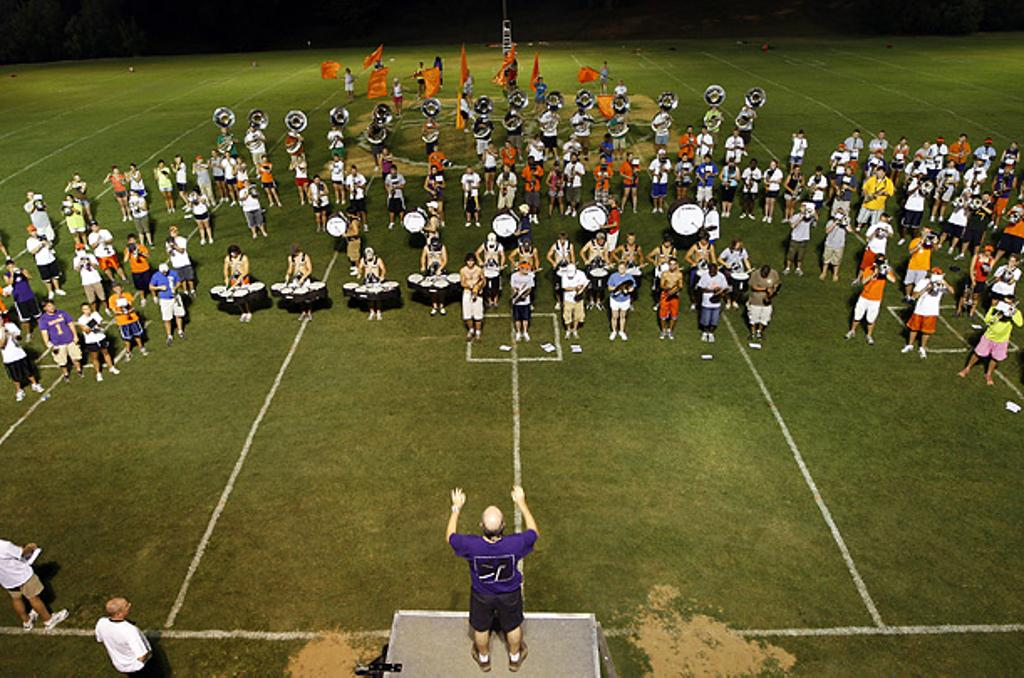

In [ ]:
img = valid[0]["image"]
img

In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import time
from datasets import load_dataset
from PIL import Image
import numpy as np
import os

# Load model
model = YOLO("/content/yolov11m-face.pt")

# Load dataset
dataset = load_dataset("CUHK-CSE/wider_face")
valid_data = dataset["validation"]

# Create temp directory to store images
os.makedirs("temp_images", exist_ok=True)

# Loop through a few samples (for example, 5)
num_samples = 100  # Change as needed
for idx in range(num_samples):
    example = valid_data[idx]

    # Get the PIL Image object
    image = example["image"]

    # Convert to RGB if not already
    image = image.convert("RGB")
    image_np = np.array(image)

    # Save temp image
    temp_path = f"temp_images/img_{idx}.jpg"
    image.save(temp_path)

    # Run inference
    results = model(temp_path)

    # Show results on detected image
    results[0].save(filename=f"temp_images/img_{idx}_det.jpg")

    # Read both images (original and detected)
    orig_img = cv2.cvtColor(cv2.imread(temp_path), cv2.COLOR_BGR2RGB)
    det_img = cv2.cvtColor(cv2.imread(f"temp_images/img_{idx}_det.jpg"), cv2.COLOR_BGR2RGB)

    # Plot side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(orig_img)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(det_img)
    ax[1].set_title("Detected")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

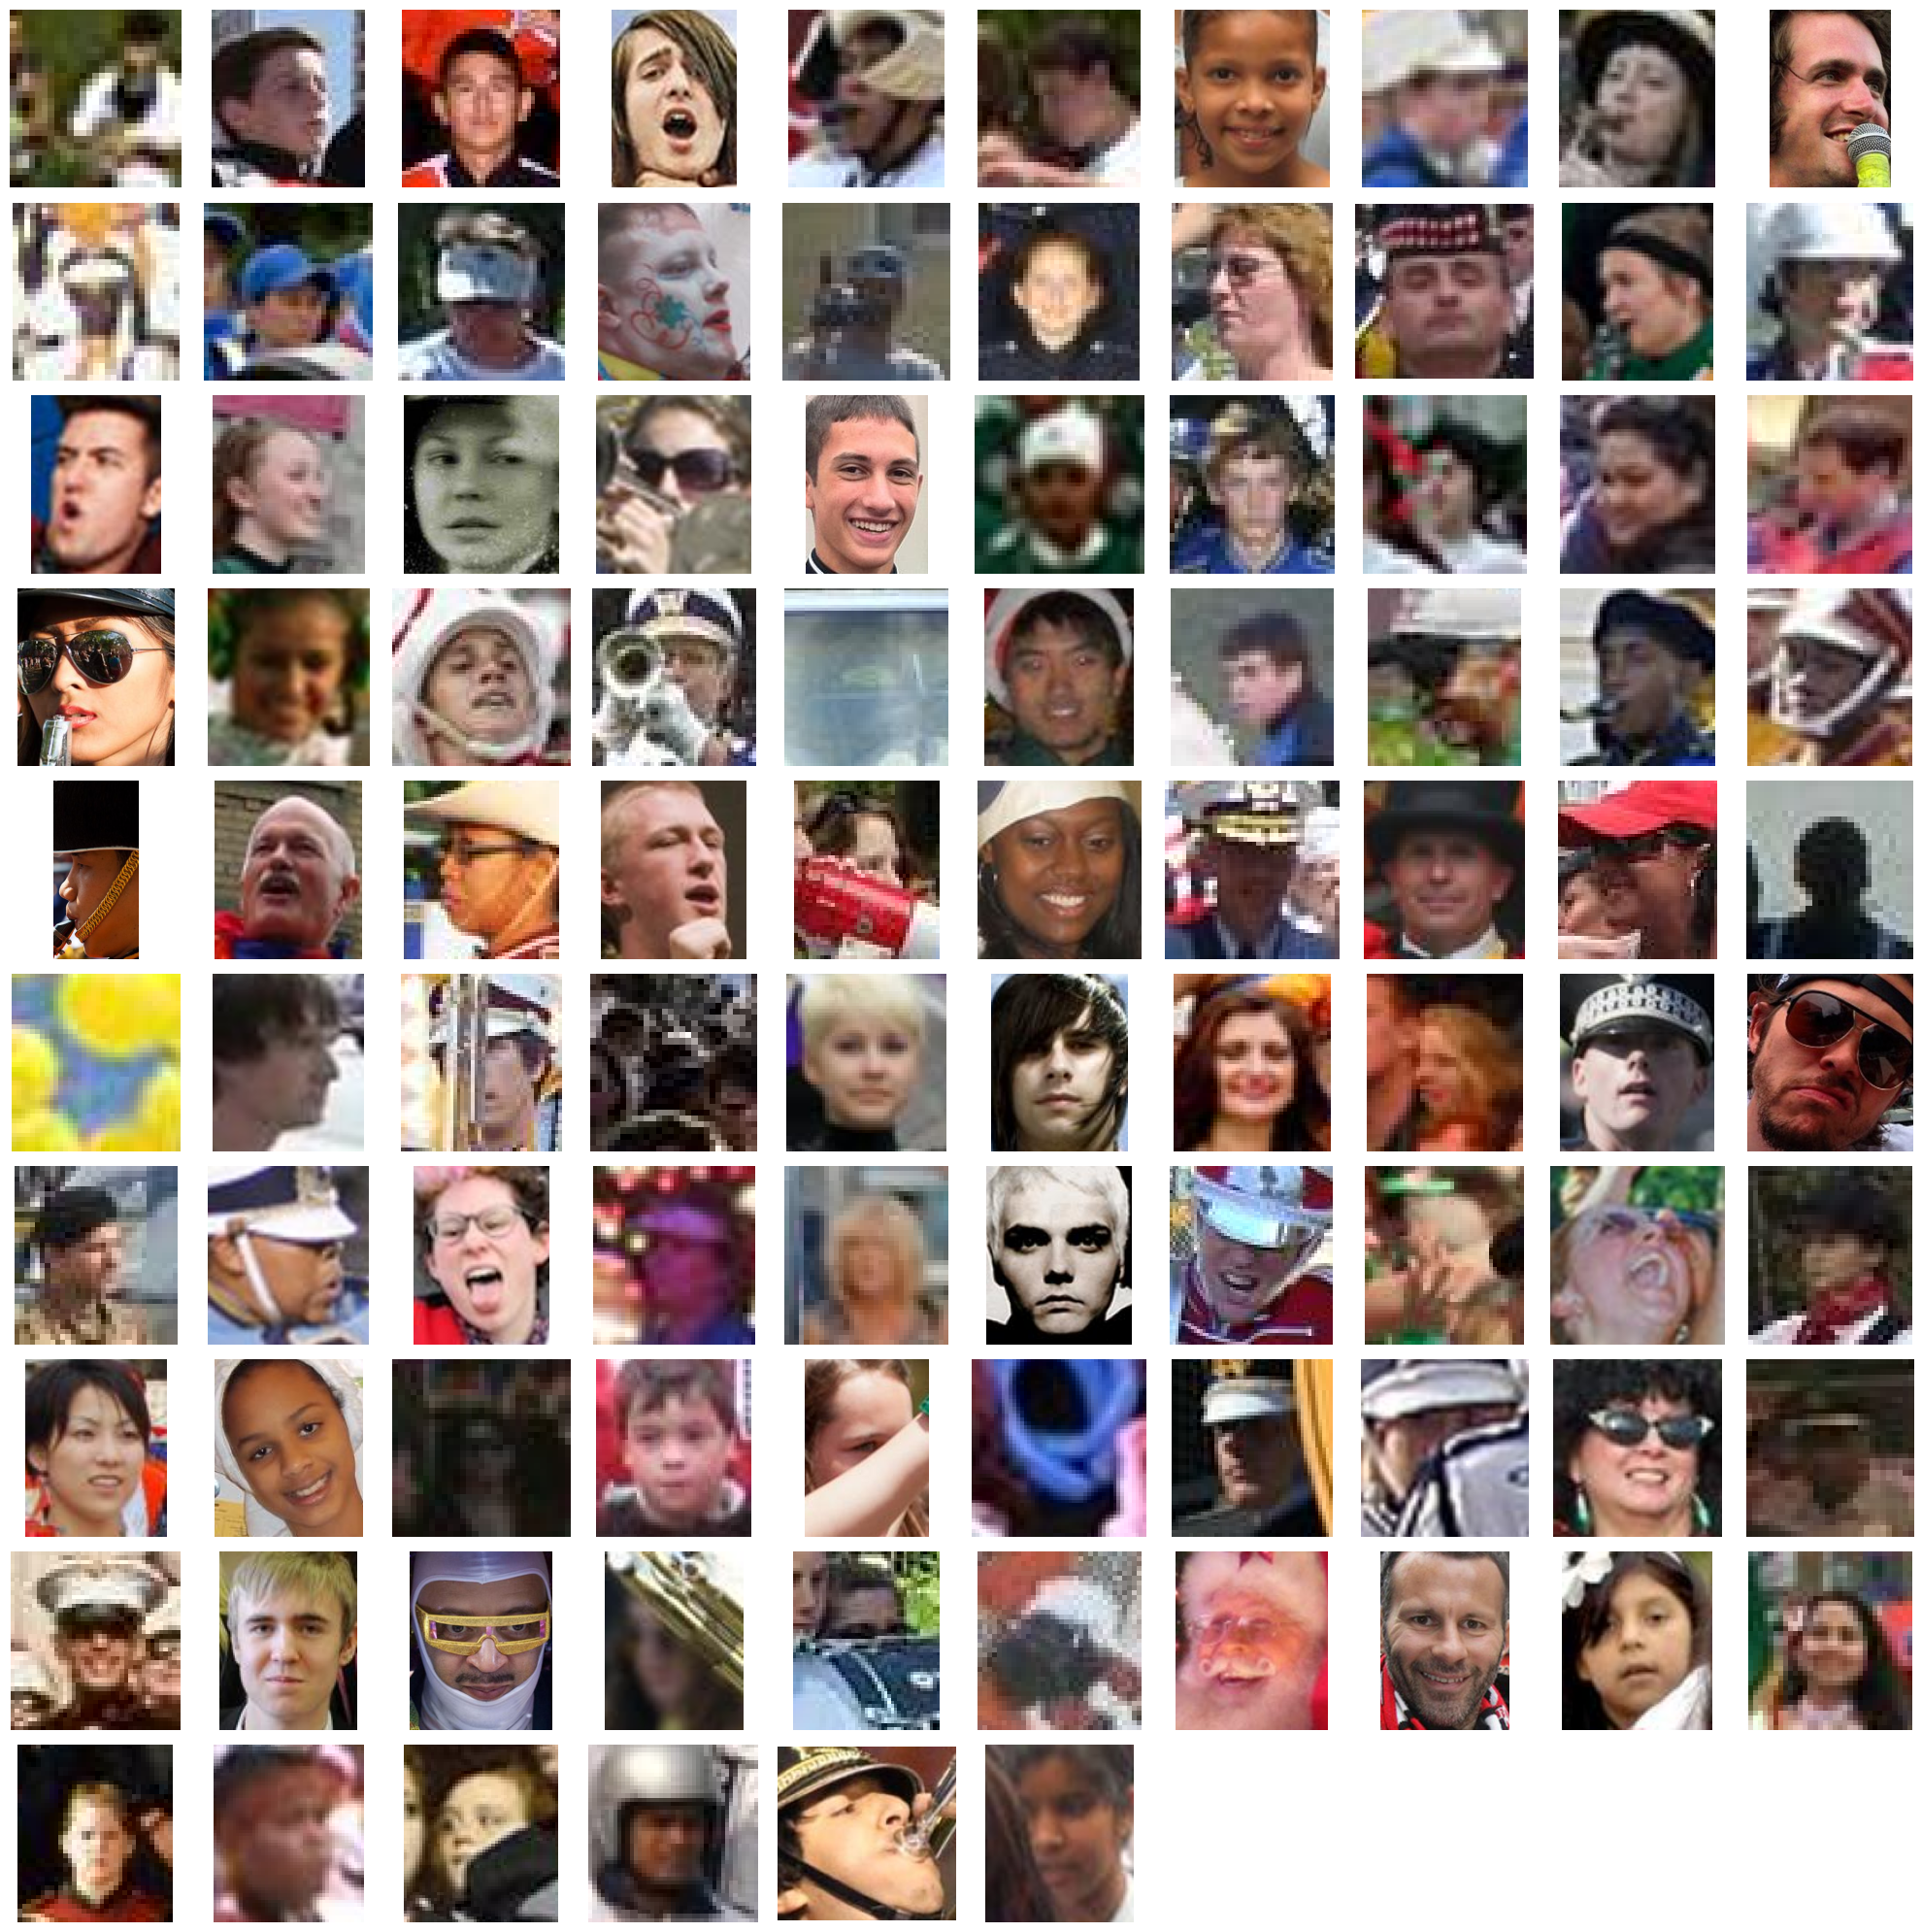

In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import time
from datasets import load_dataset
from PIL import Image
import numpy as np
import os

# Load model
model = YOLO("/content/yolov11m-face.pt")

# Load dataset
dataset = load_dataset("CUHK-CSE/wider_face")
valid_data = dataset["validation"]

# Output folders
os.makedirs("cropped_faces", exist_ok=True)

cropped_faces = []  # To store cropped face arrays
num_samples = 100   # You can change this

for idx in range(num_samples):
    example = valid_data[idx]
    image = example["image"].convert("RGB")
    image_np = np.array(image)
    h, w = image_np.shape[:2]

    # Run inference directly with numpy
    results = model.predict(source=image_np, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes is not None else []

    if len(boxes) == 0:
        continue  # Skip images with no detections

    # Find the most centered face
    image_center = np.array([w / 2, h / 2])
    best_box = min(
        boxes,
        key=lambda box: np.linalg.norm(image_center - [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])
    )

    # Crop the face with some padding
    x1, y1, x2, y2 = best_box
    padding = 10
    x1, y1, x2, y2 = max(0, int(x1) - padding), max(0, int(y1) - padding), min(w, int(x2) + padding), min(h, int(y2) + padding)
    face_crop = image_np[y1:y2, x1:x2]

    # Save and store for visualization
    cv2.imwrite(f"cropped_faces/face_{idx}.jpg", cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
    cropped_faces.append(face_crop)

# ---- Final Visualization ----
cols = 10
rows = (len(cropped_faces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < len(cropped_faces):
        ax.imshow(cropped_faces[i])
        ax.axis("off")
    else:
        ax.remove()

plt.tight_layout()
plt.show()


In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import time
from datasets import load_dataset
from PIL import Image
import numpy as np
import os

# ---------- Utils ----------
def is_blurry(image_crop, threshold=100.0):
    gray = cv2.cvtColor(image_crop, cv2.COLOR_RGB2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold

# ---------- Setup ----------
model = YOLO("/content/yolov11m-face.pt")
dataset = load_dataset("CUHK-CSE/wider_face")
valid_data = dataset["train"]

# Output folders
os.makedirs("temp_images_1", exist_ok=True)
os.makedirs("cropped_faces_1", exist_ok=True)

# Store valid face crops
cropped_faces = []

# ---------- Process ----------
num_samples = 3000  # Adjust as needed
for idx in range(num_samples):
    example = valid_data[idx]
    image = example["image"].convert("RGB")
    image_np = np.array(image)
    h, w = image_np.shape[:2]

    # Save temp image (optional, mostly for visualization)
    temp_path = f"temp_images_1/img_{idx}.jpg"
    image.save(temp_path)

    # Inference
    results = model.predict(source=image_np, verbose=False)
    boxes_data = results[0].boxes
    if boxes_data is None or len(boxes_data) == 0:
        continue

    boxes = boxes_data.xyxy.cpu().numpy()
    scores = boxes_data.conf.cpu().numpy()

    good_face_found = False

    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = map(int, box)

        # Size filter
        if (x2 - x1) < 60 or (y2 - y1) < 60:
            continue

        # Score filter
        if score < 0.83:
            continue

        # Crop and check blur
        face_crop = image_np[y1:y2, x1:x2]
        if is_blurry(face_crop, threshold=100.0):
            continue

        # Valid face found
        good_face_found = True

        # Save cropped face
        face_path = f"cropped_faces_1/face_{idx}.jpg"
        cv2.imwrite(face_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
        cropped_faces.append(face_crop)

        # Only take one face per image
        break

    # Save annotated image
    results[0].save(filename=f"temp_images_1/img_{idx}_det.jpg")

    # # Visualization
    # if good_face_found:
    #     orig_img = cv2.cvtColor(cv2.imread(temp_path), cv2.COLOR_BGR2RGB)
    #     det_img = cv2.cvtColor(cv2.imread(f"temp_images_1/img_{idx}_det.jpg"), cv2.COLOR_BGR2RGB)

    #     fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    #     ax[0].imshow(orig_img)
    #     ax[0].set_title("Original")
    #     ax[0].axis("off")

    #     ax[1].imshow(det_img)
    #     ax[1].set_title("Detected & Filtered")
    #     ax[1].axis("off")

    #     plt.tight_layout()
    #     plt.show()

# ---------- Final Visualization of All Cropped Faces ----------
if cropped_faces:
    cols = 10
    rows = (len(cropped_faces) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        if i < len(cropped_faces):
            ax.imshow(cropped_faces[i])
            ax.axis("off")
        else:
            ax.remove()

    plt.tight_layout()
    plt.show()
else:
    print("No high-quality faces detected.")


In [ ]:
len(os.listdir("/content/cropped_faces_1"))

960

In [ ]:
!pip install mtcnn opencv-python matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00


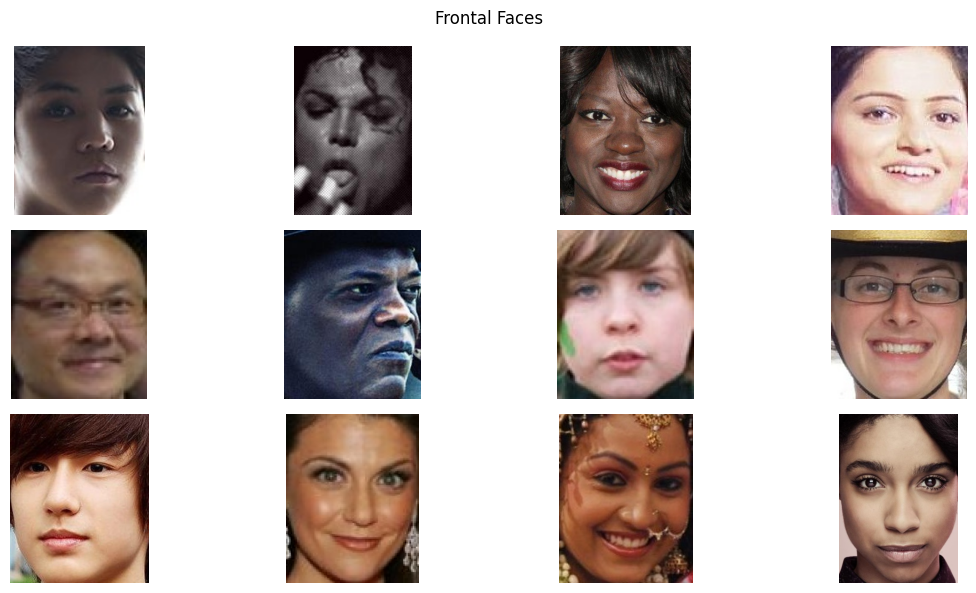

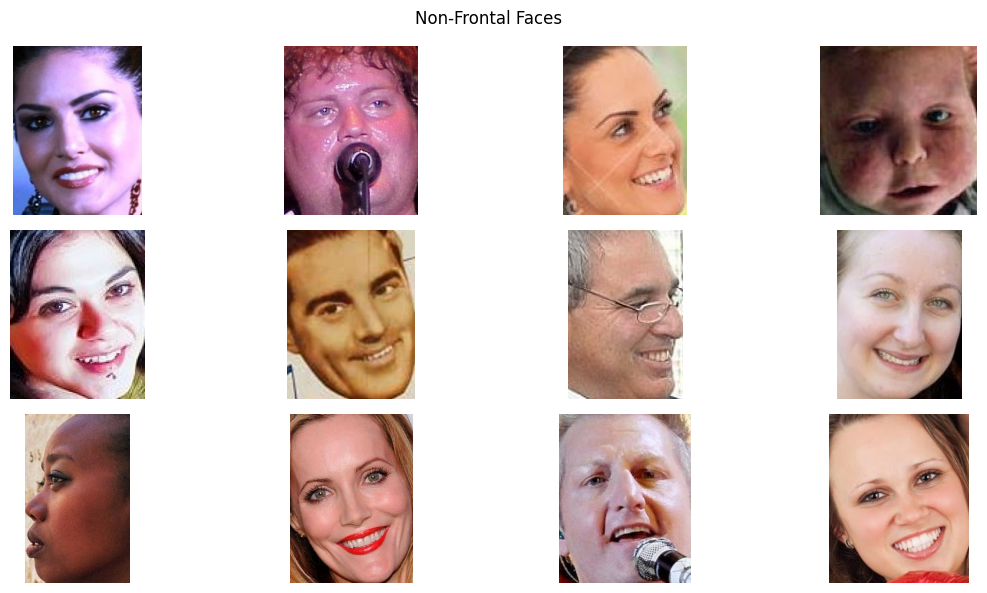

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN

# Define frontal check based on eye distance and alignment
def is_frontal(face):
    keypoints = face['keypoints']
    left_eye, right_eye = keypoints['left_eye'], keypoints['right_eye']

    eye_dx = abs(left_eye[0] - right_eye[0])
    eye_dy = abs(left_eye[1] - right_eye[1])

    if eye_dx == 0:
        return False

    tilt_ratio = eye_dy / eye_dx
    return tilt_ratio < 0.1  # Less vertical tilt = more frontal

def load_images_from_folder(folder):
    image_paths = [os.path.join(folder, f) for f in os.listdir(folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return image_paths

def process_images(folder_path):
    detector = MTCNN()
    frontal_faces = []
    non_frontal_faces = []

    for img_path in load_images_from_folder(folder_path):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        faces = detector.detect_faces(img)

        if faces:
            face = faces[0]  # use the first detected face
            if is_frontal(face):
                frontal_faces.append(img)
            else:
                non_frontal_faces.append(img)

    return frontal_faces, non_frontal_faces

def visualize_results(frontal_faces, non_frontal_faces):
    def show_images(images, title, max_imgs=12):
        plt.figure(figsize=(12, 6))
        for i, img in enumerate(images[:max_imgs]):
            plt.subplot(3, 4, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    show_images(frontal_faces, "Frontal Faces")
    show_images(non_frontal_faces, "Non-Frontal Faces")

# === MAIN CALL ===
folder_path = '/content/cropped_faces_1'  # <<< CHANGE THIS
frontal, non_frontal = process_images(folder_path)
visualize_results(frontal, non_frontal)


## image ni height ane width vadhari che

In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import time
from datasets import load_dataset
from PIL import Image
import numpy as np
import os
import torch
from tqdm import tqdm  # <-- Progress bar!

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model to CUDA if available
model = YOLO("/content/yolov11m-face.pt")
model.to(device)

# Load dataset
dataset = load_dataset("CUHK-CSE/wider_face")
valid_data = dataset["validation"]

# Output folder
os.makedirs("cropped_faces", exist_ok=True)

cropped_faces = []  # To store cropped face arrays
num_samples = 1000   # You can change this
scale = 2.0         # Increase this to get more padding around the face

# Loop with tqdm progress bar
for idx in tqdm(range(num_samples), desc="Processing images"):
    example = valid_data[idx]
    image = example["image"].convert("RGB")
    image_np = np.array(image)
    h, w = image_np.shape[:2]

    # Run inference
    results = model.predict(source=image_np, verbose=False, device=device.index if device.type == "cuda" else None)
    boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes is not None else []

    if len(boxes) == 0:
        continue  # Skip images with no detections

    # Find the most centered face
    image_center = np.array([w / 2, h / 2])
    best_box = min(
        boxes,
        key=lambda box: np.linalg.norm(image_center - [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])
    )

    # Get box coordinates
    x1, y1, x2, y2 = best_box
    box_w = x2 - x1
    box_h = y2 - y1
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    # Scale the bounding box
    new_w = box_w * scale
    new_h = box_h * scale
    x1_new = max(0, int(center_x - new_w / 2))
    y1_new = max(0, int(center_y - new_h / 2))
    x2_new = min(w, int(center_x + new_w / 2))
    y2_new = min(h, int(center_y + new_h / 2))

    # Crop the face with extra padding
    face_crop = image_np[y1_new:y2_new, x1_new:x2_new]

    # Save and store for visualization
    cv2.imwrite(f"cropped_faces/face_{idx}.jpg", cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
    cropped_faces.append(face_crop)

# ---- Final Visualization ----
cols = 10
rows = (len(cropped_faces) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < len(cropped_faces):
        ax.imshow(cropped_faces[i])
        ax.axis("off")
    else:
        ax.remove()

plt.tight_layout()
plt.show()


## de